<a href="https://colab.research.google.com/github/LebedevIurii/zda-sem/blob/main/Lebediur_sem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pro moznost prace se souboremi .pgn.zst nainstalujeme si moduly "zstandard", "chess" a "utils".

In [26]:
!pip install zstandard
!pip install chess
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Vetsina dat se uklada do Google Drivu, a proto si dame pristup

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## *Importy*

In [28]:
from matplotlib import scale
import utils as ut
import chess
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import zstandard as zstd
import io
import chess.pgn
from pathlib import Path
import numpy as np
import pandas as pd
import csv
import copy

## Parsovani datovych zdroju

In [29]:
input_files = ["/content/drive/MyDrive/chess-data/lichess_db_standard_rated_2014-01.pgn.zst","/content/drive/MyDrive/chess-data/lichess_db_standard_rated_2014-09.pgn.zst", "/content/drive/MyDrive/chess-data/lichess_db_standard_rated_2016-03.pgn.zst"]
output_file = "/content/drive/MyDrive/chess-data/data.pgn"
with open(output_file, 'wb') as outfile:
    for i in input_files:
        # Open the input file in binary mode
        with open(i, 'rb') as infile:
            dctx = zstd.ZstdDecompressor()
            
            # Open the output file in binary mode
            reader = dctx.stream_reader(infile)
            
            # Read and decompress the data in chunks
            chunk_size = 4096
            while True:
                chunk = reader.read(chunk_size)
                if not chunk:
                    break
                    
                    # Write the decompressed data to the output file
                outfile.write(chunk)

print("Decompression complete.")


Decompression complete.


## Po dekompresse ukladame potrebna data do souboru parsed-data-csv.csv

In [30]:
pgn = open("/content/drive/MyDrive/chess-data/data.pgn")
output_csv = "/content/drive/MyDrive/chess-data/parsed-data-csv.csv" 

player = {
    'game' : '',
    'win' : '',
    'color' : '',
    'opening' : '',
    'f_move' : ''
}


with open(output_csv, mode='w', newline='') as output:
    writer = csv.writer(output)
    writer.writerow(['Game','Result','Color','Opening','FirstMove'])
    game_count = 0
    while True:
        game = chess.pgn.read_game(pgn)
        results = [copy.deepcopy(player), copy.deepcopy(player)]
        if game is None or game.is_end():
            break
        game_name = game.headers['White'] + "_" + game.headers['Black'] + "_" + game.headers['UTCDate'] + "_" + game.headers['UTCTime']
        r_header = game.headers['Result'].split("-")
        o_header = game.headers['Opening']
        openings = o_header.split(", ")
        f_move = [''] * 2
        i = 0
        for move in game.mainline_moves():
            f_move[i] = move
            if i > 0:
                break;
            i += 1
        for i in range(len(results)):
            results[i]['game'] = game_name
            results[i]['win'] = r_header[i]
            if i == 0: results[i]['color'] = 'white'
            elif i == 1: results[i]['color'] = 'black'
            if i < len(openings): results[i]['opening'] = openings[i]
            else: results[i]['opening'] = '--'
            if type(f_move[i]) == str: results[i]['f_move'] = f_move[i]
            else: results[i]['f_move'] = f_move[i].uci()
            writer.writerow([results[i]['game'],results[i]['win'],results[i]['color'],results[i]['opening'],results[i]['f_move']])
        game_count += 1
        game = chess.pgn.read_game(pgn)

with open(output_csv, 'r') as file:
    reader = csv.reader(file)

    for row in reader:
        print(row)
print(game_count)

Выходные данные были обрезаны до нескольких последних строк (5000).
['bauk_Triceratops_2007_2014.01.01_23:09:13', '0', 'black', '--', 'b7b6']
['nady8813_dediraut_2014.01.01_23:08:30', '1', 'white', 'Vienna Game', 'e2e4']
['nady8813_dediraut_2014.01.01_23:08:30', '0', 'black', '--', 'e7e5']
['n1k0s_donluis_2014.01.01_23:09:38', '1', 'white', 'Sicilian Defense: Smith-Morra Gambit #2', 'e2e4']
['n1k0s_donluis_2014.01.01_23:09:38', '0', 'black', '--', 'c7c5']
['houdjini_ribarisah_2014.01.01_23:09:47', '1', 'white', 'English Defense #2', 'd2d4']
['houdjini_ribarisah_2014.01.01_23:09:47', '0', 'black', '--', 'b7b6']
['Joueurfel_jgg2000_2014.01.01_23:08:01', '1', 'white', 'Alekhine Defense: Maroczy Variation', 'e2e4']
['Joueurfel_jgg2000_2014.01.01_23:08:01', '0', 'black', '--', 'g8f6']
['sd39_tolia_2014.01.01_23:08:14', '1', 'white', "King's Pawn Game: Leonardis Variation", 'e2e4']
['sd39_tolia_2014.01.01_23:08:14', '0', 'black', '--', 'e7e5']
['JRCGMS_belja_2014.01.01_23:08:07', '0', 'white

## Sjednoceni dat do jednoho formatu hry

In [31]:
df = pd.read_csv("/content/drive/MyDrive/chess-data/parsed-data-csv.csv")

unique_F_M = df.drop_duplicates(subset=["FirstMove", "Color"])
white_F_M = df[df["Color"] == "white"]
black_F_M = df[df["Color"] == "black"]
u_white_F_M = unique_F_M[unique_F_M["Color"] == "white"]
u_black_F_M = unique_F_M[unique_F_M["Color"] == "black"]

mergedW = pd.merge(white_F_M, black_F_M, on='Game')
mergedB = pd.merge(black_F_M, white_F_M, on='Game')

mergedW= mergedW[["FirstMove_x", "FirstMove_y"]]
mergedB= mergedB[["FirstMove_x", "FirstMove_y"]]

merged = mergedW
for i in range(len(mergedB)):
  merged.loc[len(merged)] = mergedB.iloc[i]


*Pivotni tabulka*

In [32]:
pivot_table = merged.pivot_table(columns="FirstMove_y", index="FirstMove_x", aggfunc='size', fill_value=-1)

pivot_table

FirstMove_y,a2a3,a2a4,a7a5,a7a6,b1c3,b2b3,b2b4,b7b5,b7b6,b8c6,...,g2g3,g2g4,g7g5,g7g6,g8f6,g8h6,h2h3,h2h4,h7h5,h7h6
FirstMove_x,,,,,,,,,,,,,,,,,,,,,
a2a3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,-1
a2a4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,-1
a7a5,-1,-1,-1,-1,-1,2,1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
a7a6,-1,-1,-1,-1,-1,1,1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
b1c3,-1,-1,-1,-1,-1,-1,-1,-1,2,1,...,-1,-1,-1,1,3,-1,-1,-1,-1,-1
b2b3,-1,-1,2,1,-1,-1,-1,-1,13,4,...,-1,-1,1,16,6,-1,-1,-1,1,-1
b2b4,-1,-1,1,1,-1,-1,-1,1,-1,1,...,-1,-1,-1,4,2,-1,-1,-1,-1,-1
b7b5,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,-1,-1
b7b6,-1,-1,-1,-1,2,13,-1,-1,-1,-1,...,7,-1,-1,-1,-1,-1,-1,-1,-1,-1


# Vyhledavani statistiky prvniho tahu kazde strany pomoci pivotni tabulky 

In [33]:
counted_White = white_F_M["FirstMove"].value_counts()
counted_Black = black_F_M["FirstMove"].value_counts()

hist_W_F_M = {'First Move' : [],
                 'Count' : []}
hist_B_F_M = {'First Move' : [],
                 'Count' : []}

un_W = white_F_M["FirstMove"].drop_duplicates()
un_B = black_F_M["FirstMove"].drop_duplicates()

for move in un_W:
    hist_W_F_M['First Move'].append(move)
for move in counted_White:
    hist_W_F_M['Count'].append(move)

for move in un_B:
    if (move != move): hist_B_F_M['First Move'].append('b8a6')
    else: hist_B_F_M['First Move'].append(move)
for move in counted_Black:
    hist_B_F_M['Count'].append(move)

if(len(hist_B_F_M['Count']) < 20):
    for move in range(20 - len(hist_B_F_M['Count'])):
        hist_B_F_M['Count'].append(0)

move_W = px.histogram(hist_W_F_M, x = "First Move", y = "Count", text_auto = '.0f', template = 'presentation', title='The most common opening moves in chess: White side')
move_B = px.histogram(hist_B_F_M, x = "First Move", y = "Count", text_auto = '.0f', template = 'presentation', title='The most common opening moves in chess: Black side')
move_W.show()
move_B.show()

## Vizualizace nejpopularnejsich

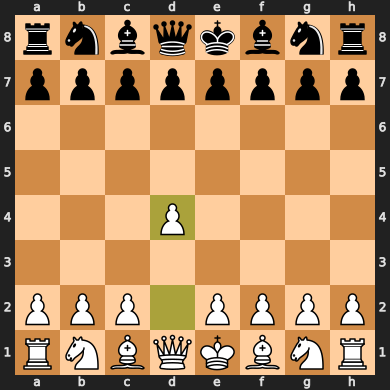

In [34]:
mostpopular = chess.Board()
a_list = hist_W_F_M["Count"]

max_ind = a_list.index(max(a_list))
mostpopular.push(chess.Move.from_uci(hist_W_F_M["First Move"][max_ind]))
mostpopular

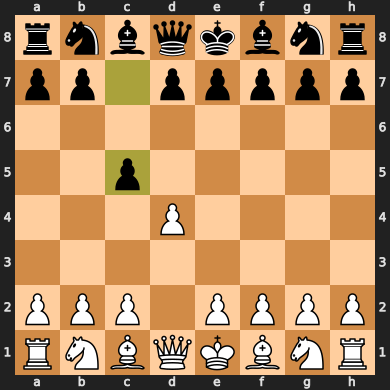

In [35]:
a_list = hist_B_F_M["Count"]

max_ind = a_list.index(max(a_list))
mostpopular.push(chess.Move.from_uci(hist_B_F_M["First Move"][max_ind]))
mostpopular

## Correlacni mapa

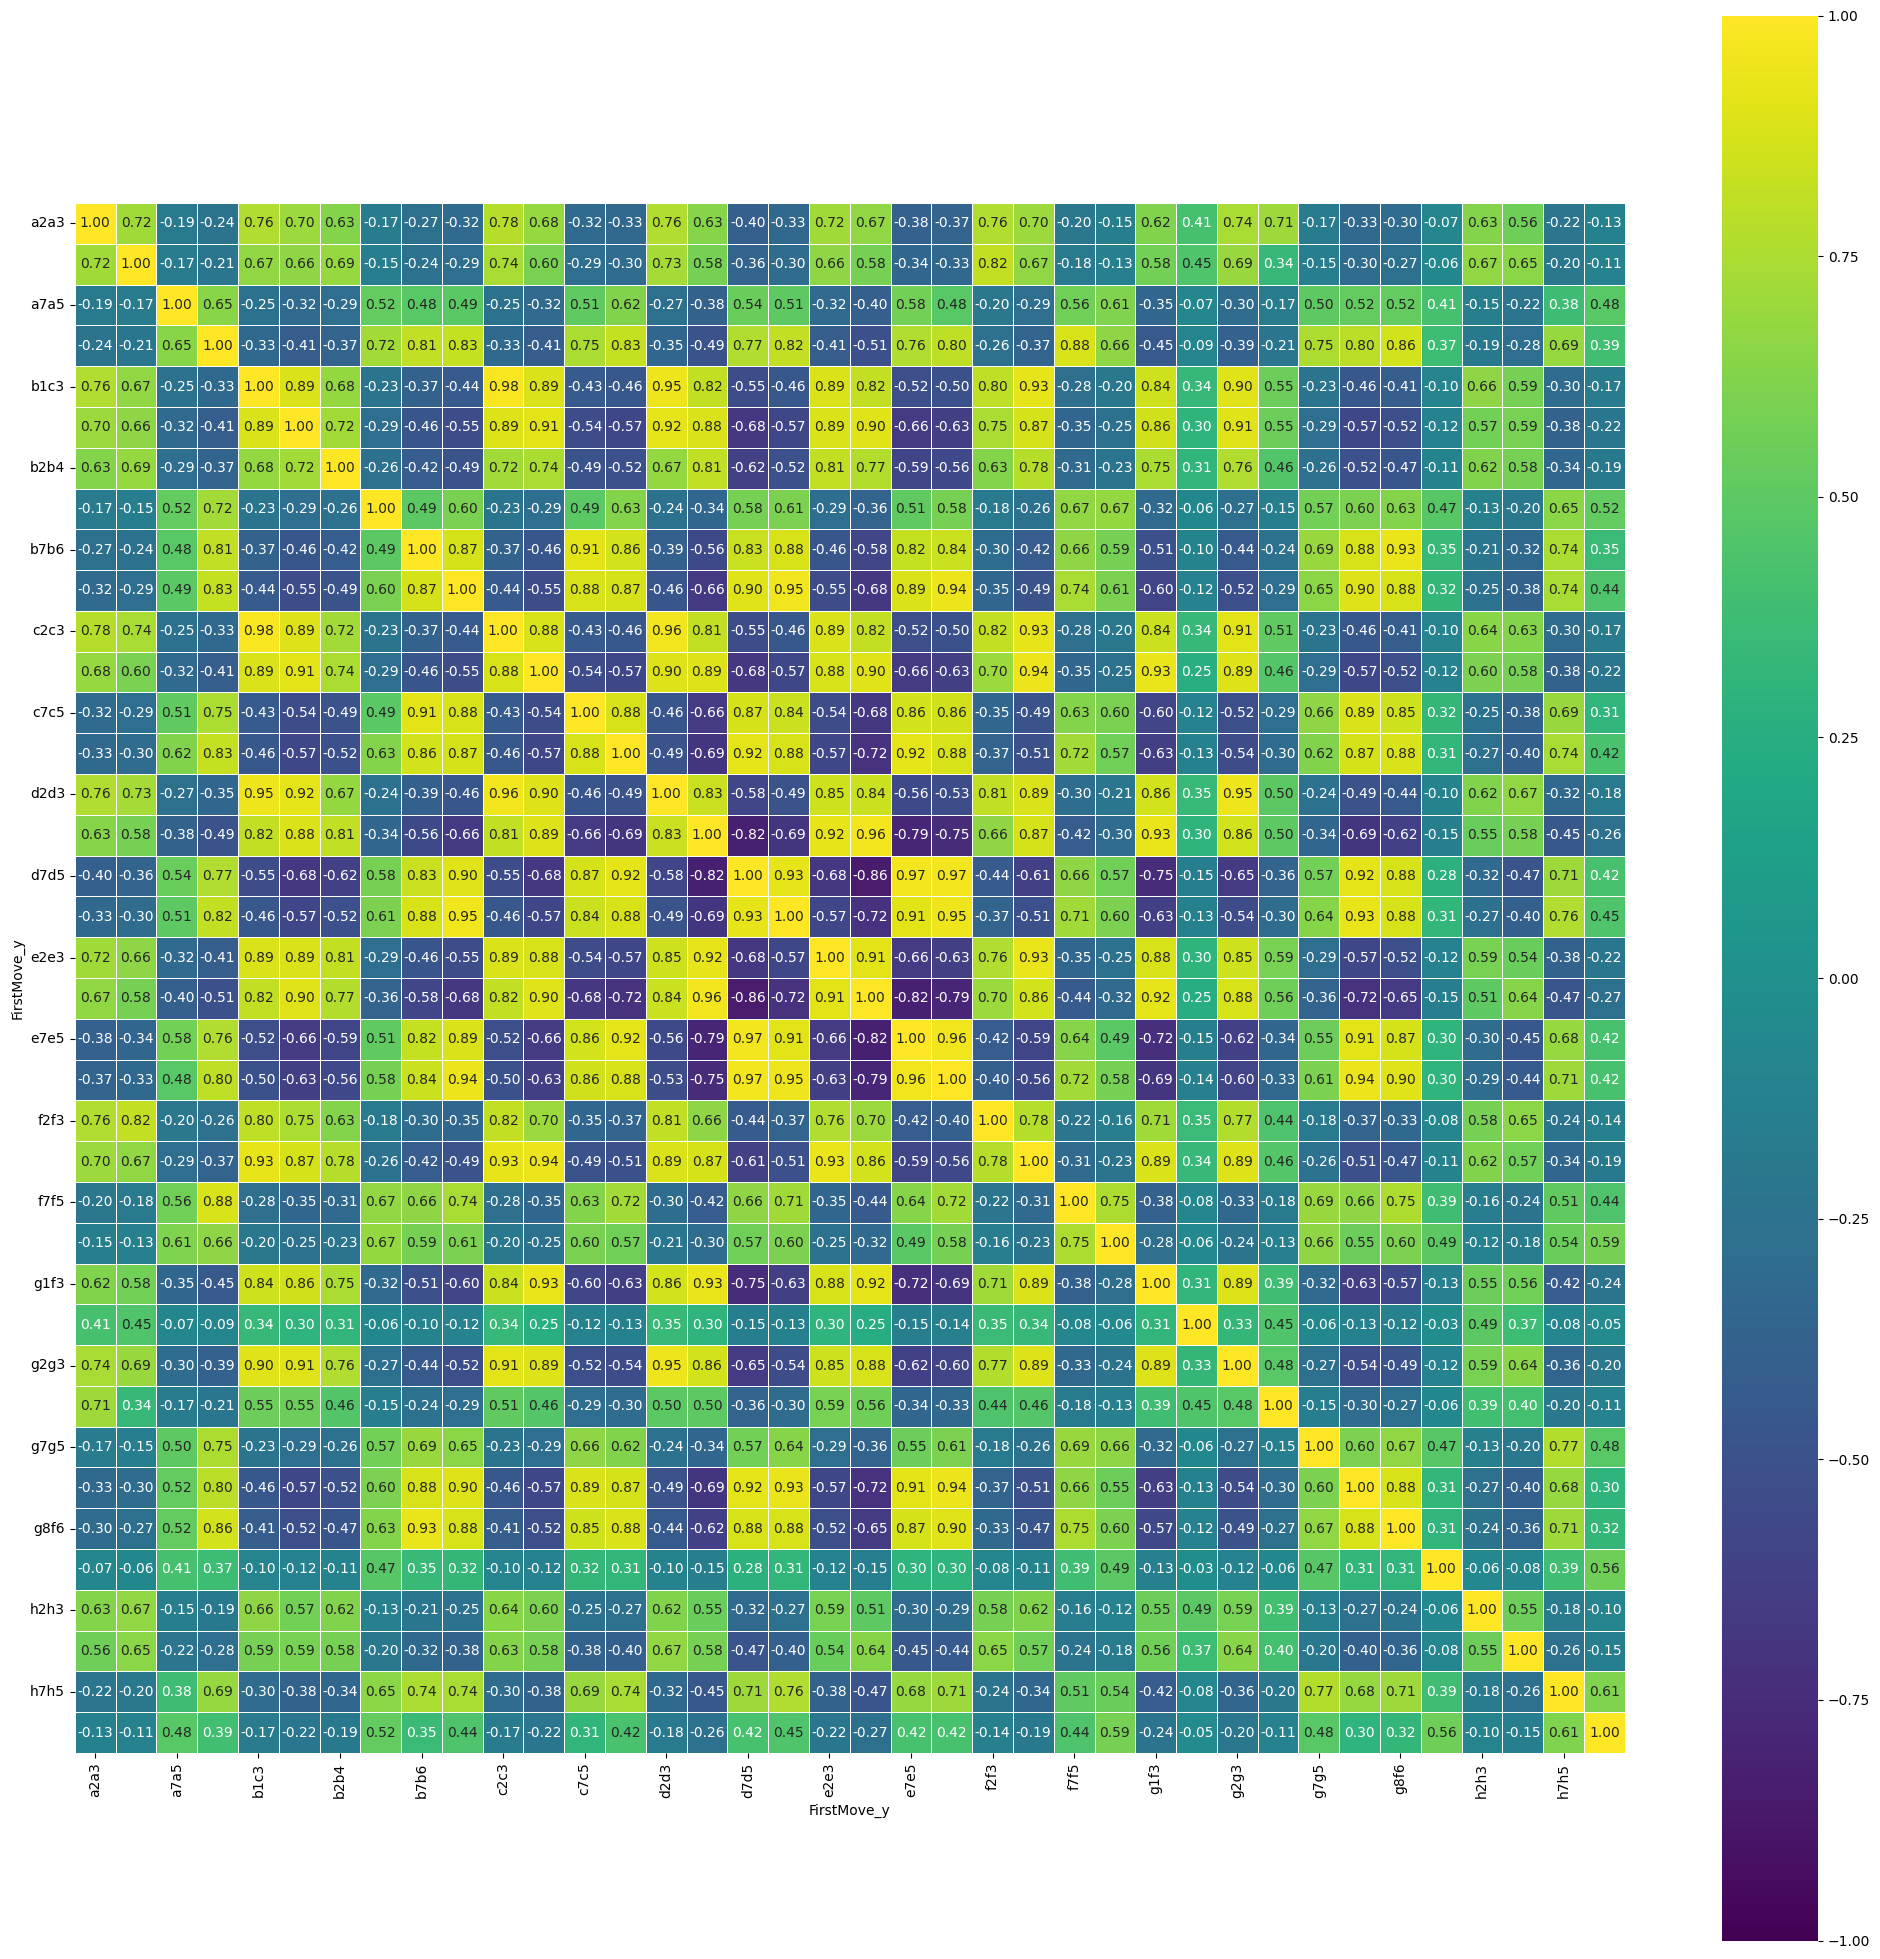

In [36]:
ax = sns.heatmap(pivot_table.corr(method= "spearman"), cmap='viridis', vmax=1, center=0, vmin=-1, square=True, linewidths=0.5,  annot=True, fmt=".2f")
ax.figure.set_size_inches(25, 25)

## Analyza a vizualzace zavislosti uspesnosti hry na prvnim tahu na zaklade statistiky

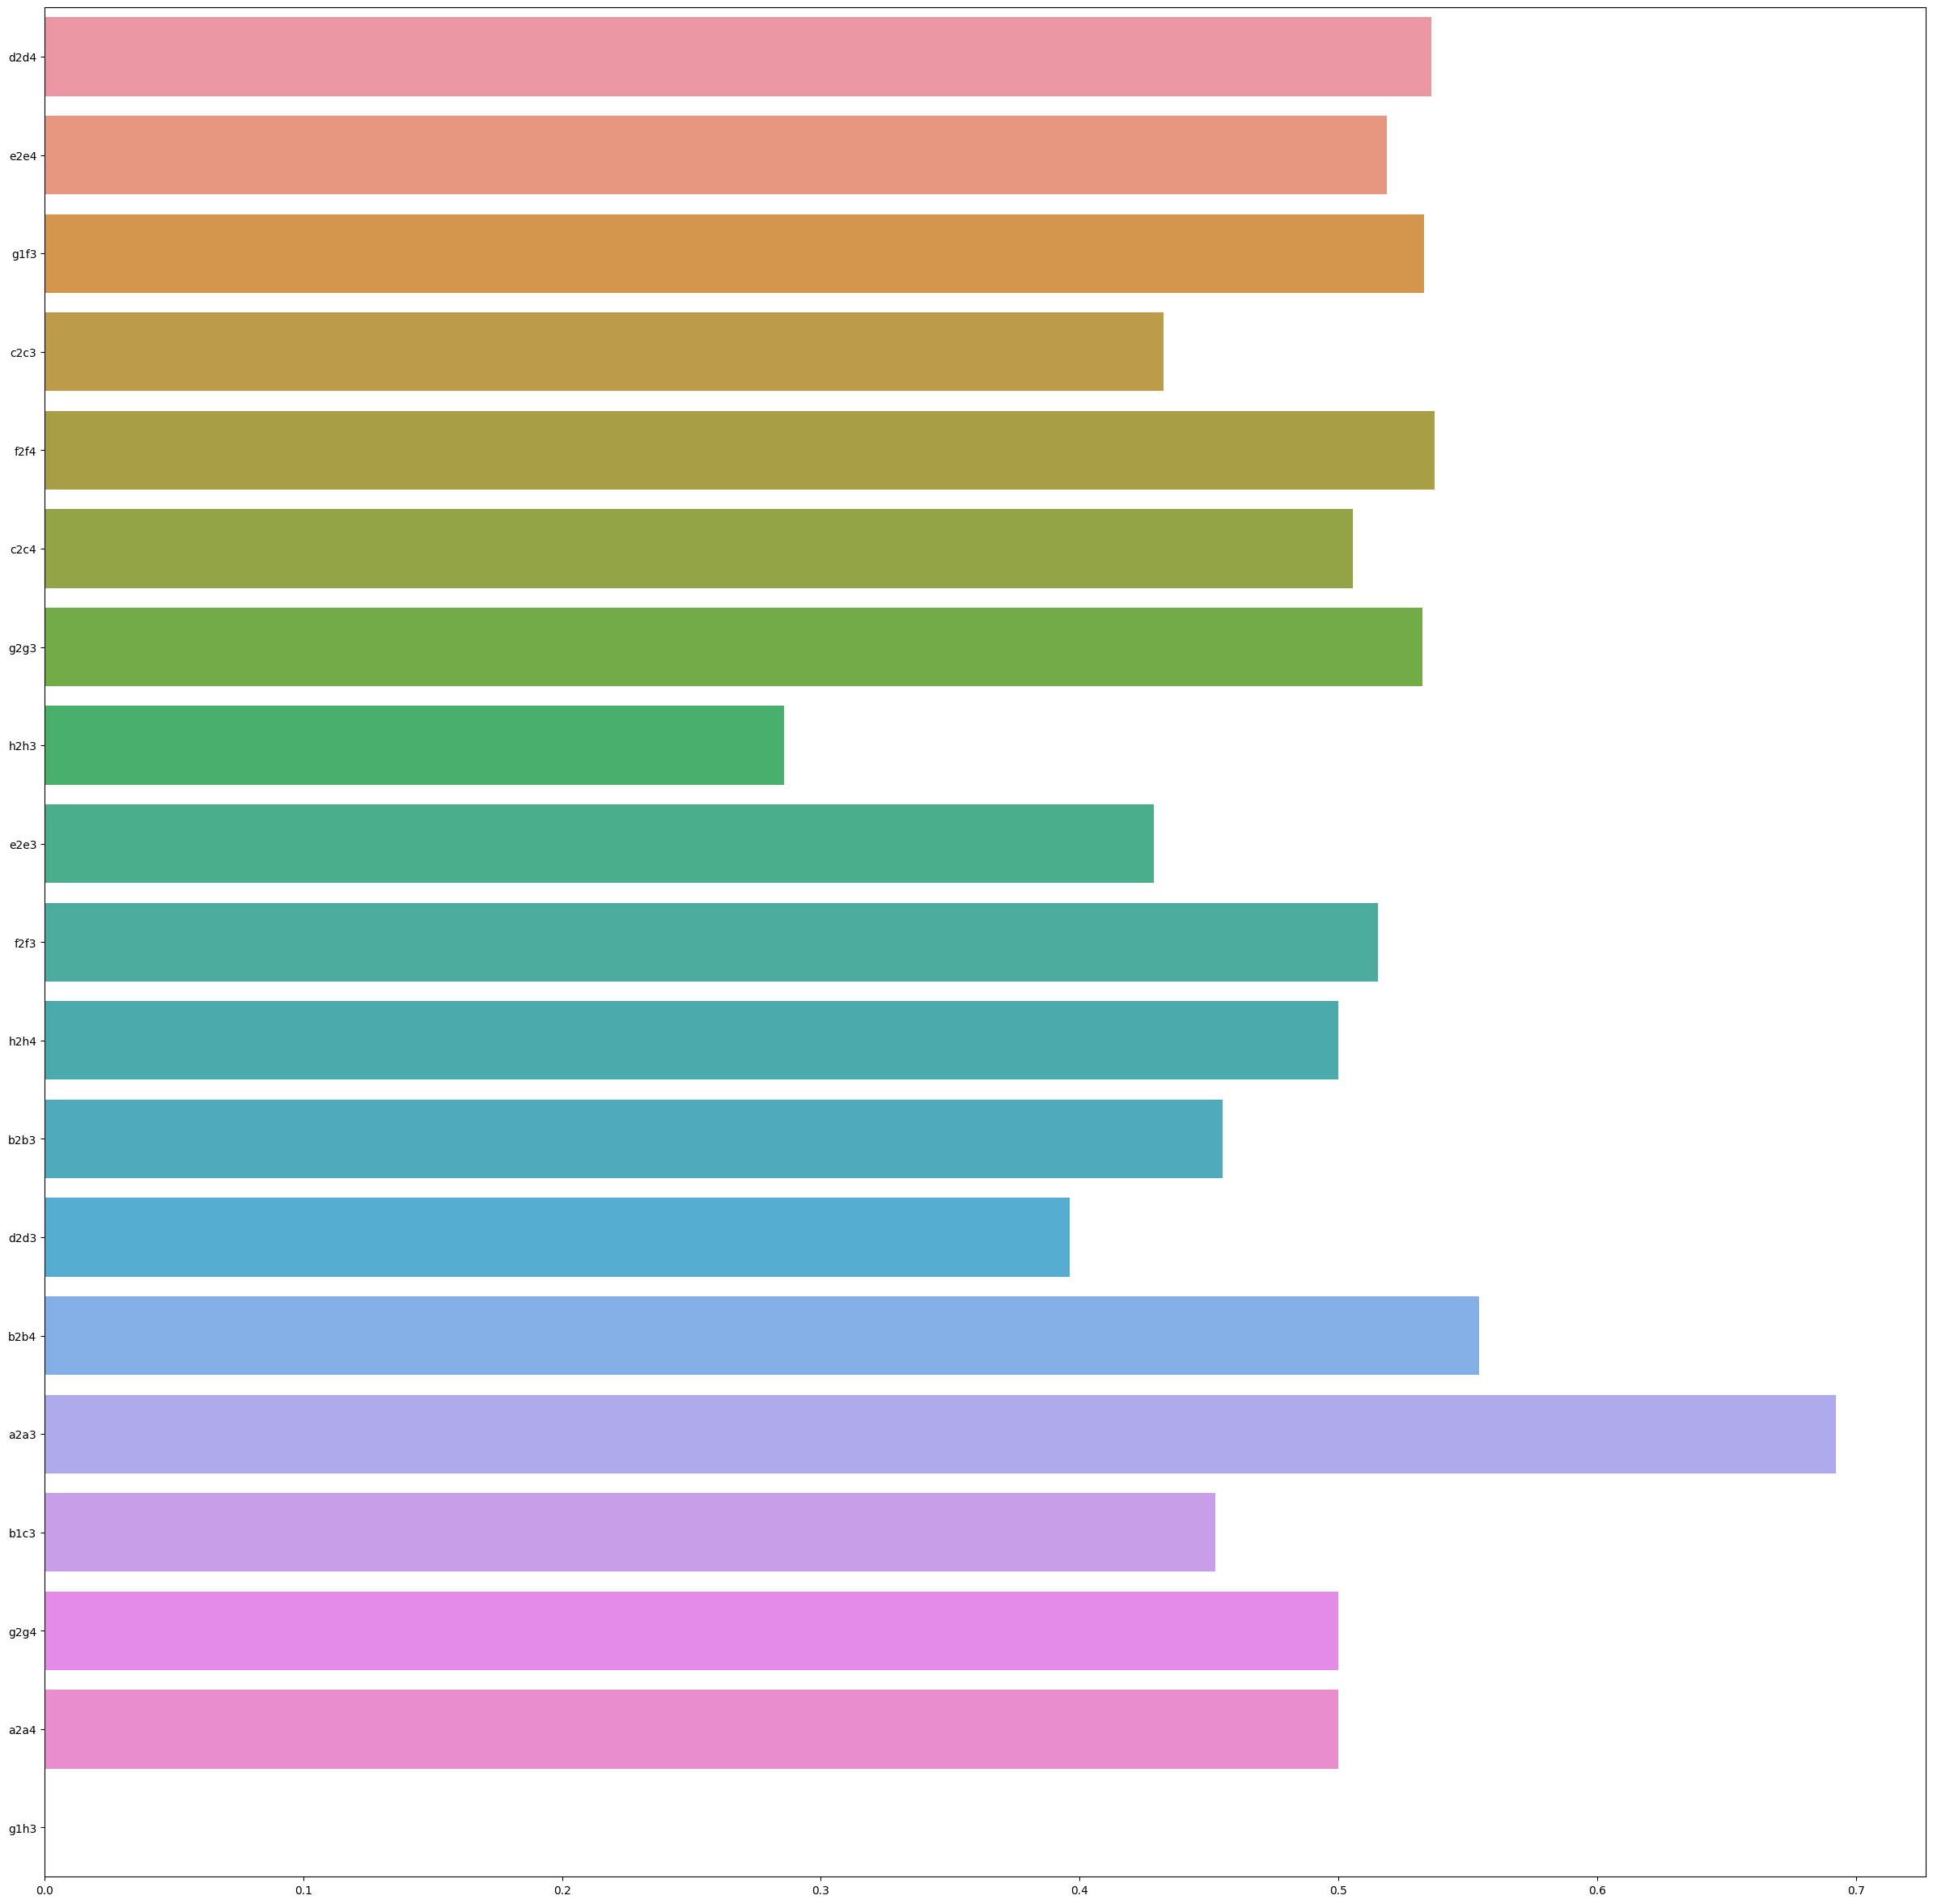

In [37]:
counted_White = white_F_M[["FirstMove", "Result"]].value_counts().reset_index()


uW_O = white_F_M["FirstMove"].str.split(",")

uW_O = uW_O.drop_duplicates()

prob_W = {'First Move' : [],
          'Probability of Win' : []}

for el in uW_O:
    str_el = el[0].strip()
    prob_W['First Move'].append(str_el)
    wins = counted_White[(counted_White["FirstMove"] == str_el) & (counted_White["Result"] == '1')].reset_index()[0]
    if len(wins) == 0: wins = 0
    else:
        for elem in wins:
            wins = elem
    loses = counted_White[(counted_White["FirstMove"] == str_el) & (counted_White["Result"] == '0')].reset_index()[0]
    if len(loses) == 0: loses = 0
    else:
        for elem in loses:
            loses = elem
    draws = counted_White[(counted_White["FirstMove"] == str_el) & (counted_White["Result"] == '1/2')].reset_index()[0]
    if len(draws) == 0: draws = 0
    else:
        for elem in draws:
            draws = elem
    prob_W['Probability of Win'].append(float(wins / (wins + loses + draws)))

jp = sns.barplot(prob_W, x='Probability of Win', y='First Move')
jp.figure.set_size_inches(30, 30)

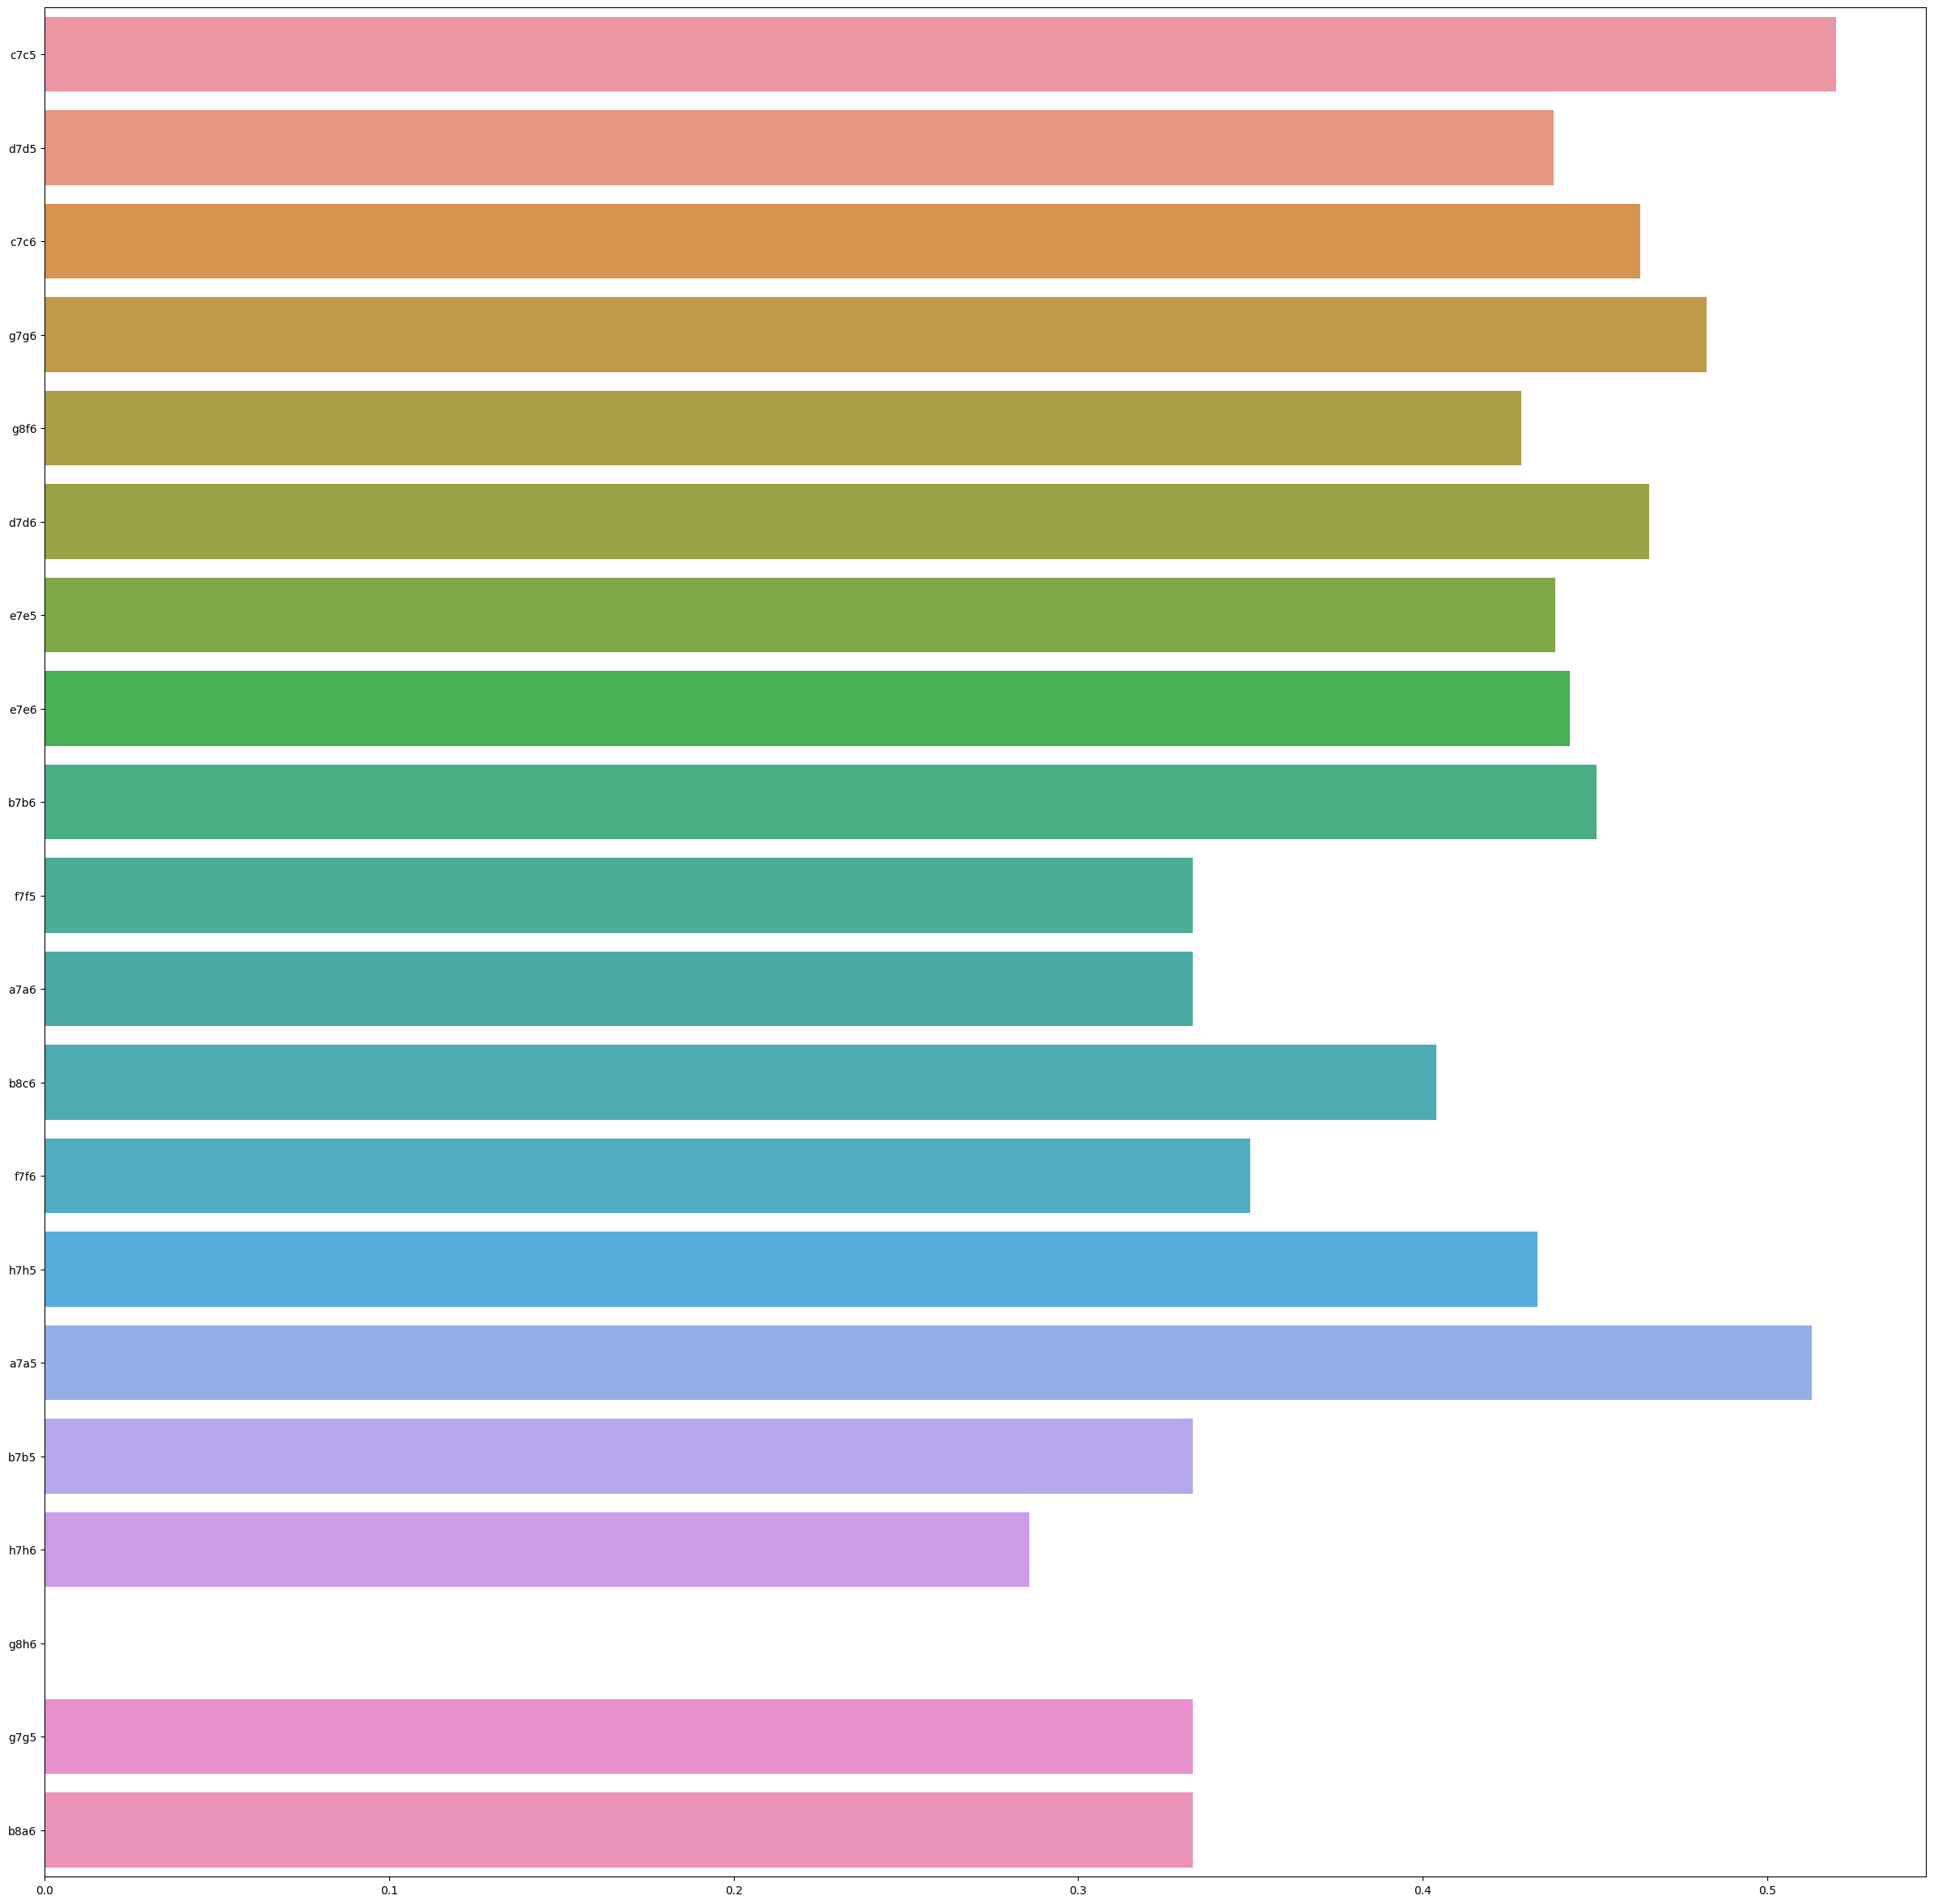

In [38]:
counted_Black = black_F_M[["FirstMove", "Result"]].value_counts().reset_index()
uB_O = black_F_M["FirstMove"]

uB_O = uB_O.drop_duplicates()

prob_B = {'First Move' : [],
          'Probability of Win' : []}

for el in uB_O:
    if (el != el): 
        prob_B['First Move'].append('b8a6')
    else: 
        str_el = el
        prob_B['First Move'].append(str_el)
    wins = counted_Black[(counted_Black["FirstMove"] == str_el) & (counted_Black["Result"] == '1')].reset_index()[0]
    if len(wins) == 0: wins = 0
    else:
        for elem in wins:
            wins = elem
    loses = counted_Black[(counted_Black["FirstMove"] == str_el) & (counted_Black["Result"] == '0')].reset_index()[0]
    if len(loses) == 0: loses = 0
    else:
        for elem in loses:
            loses = elem
    draws = counted_Black[(counted_Black["FirstMove"] == str_el) & (counted_Black["Result"] == '1/2')].reset_index()[0]
    if len(draws) == 0: draws = 0
    else:
        for elem in draws:
            draws = elem
    if wins + loses + draws == 0: prob_B['Probability of Win'].append(0)
    else: prob_B['Probability of Win'].append(float(wins / (wins + loses + draws)))

jp = sns.barplot(prob_B, x='Probability of Win', y='First Move')
jp.figure.set_size_inches(30, 30)

## Vizualizace nejuspesnejsich

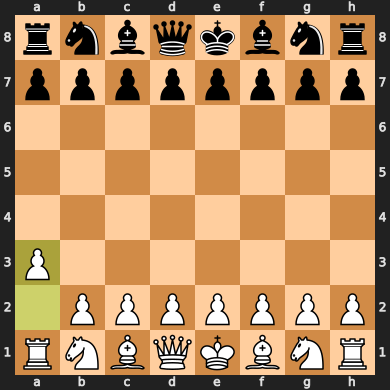

In [39]:
winner = chess.Board()
a_list = prob_W["Probability of Win"]

max_ind = a_list.index(max(a_list))
winner.push(chess.Move.from_uci(prob_W["First Move"][max_ind]))
winner

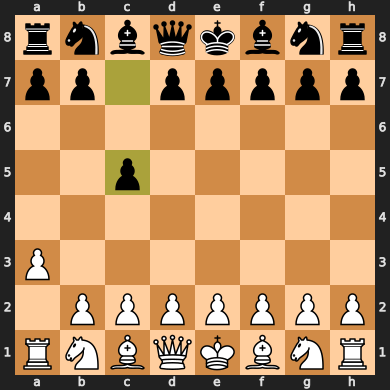

In [40]:
a_list = prob_B["Probability of Win"]

max_ind = a_list.index(max(a_list))
winner.push(chess.Move.from_uci(prob_B["First Move"][max_ind]))
winner

# Zaver

Na zaklade analyzy okolo 12500 her nejcastesim tahy bile strany je d2d4, a pro cernou stranu c7c5

Vyhra se s největší pravděpodobností nastava podle statistiky pri prvnim tahu a2a3 pro bile a c7c5 pro cerne.

Teto analyze neni mozne verit jako 100%, kvuli tomu ze data se v uvahu neberou skill hrace a jeste kvuli tomu ze vyhra zasvisi na vicero parametrech